# MRC_valitadionset

In [1]:
#import packages
import pandas as pd
import numpy as np
import os
import math

# data visualizaion
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple

# pip install missingno
import missingno as msno
import pprint


# load for MRC datasets
from datasets import load_from_disk

# load for Retrieval dataset
import json


In [2]:
DATA_PATH = "../../data/"

mrc_train_dataset = load_from_disk(os.path.join(DATA_PATH,"train_dataset"))
print(mrc_train_dataset)

# train / validation 분리
# 데이터 구조 중, 필요없는 컬럼인 '__index_level_0__' , 'document_id' 제거

train_dataset = mrc_train_dataset['train'].remove_columns(['__index_level_0__','document_id'])
validation_dataset = mrc_train_dataset['validation'].remove_columns(['__index_level_0__','document_id'])

# Train 데이터 셋 중 train 비율
print(f"*"*20)
print(f"Total Train Dataset Count : {validation_dataset.num_rows} ")
print(f"Train Dataset Ratio: { validation_dataset.num_rows / (train_dataset.num_rows + validation_dataset.num_rows):.2f} ")


DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})
********************
Total Train Dataset Count : 240 
Train Dataset Ratio: 0.06 


## 데이터 개요

In [3]:
print(validation_dataset[0])
# type(validation_dataset)

# arrow_dataset to pandas
validation_dataset = pd.DataFrame(validation_dataset)
validation_dataset.head()

{'title': '전효숙', 'context': '순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법시험에 합격하여 판사로 임용되었고 대법원 재판연구관, 수원지법 부장판사, 사법연수원 교수, 특허법원 부장판사 등을 거쳐 능력을 인정받았다. 2003년 최종영 대법원장의 지명으로 헌법재판소 재판관을 역임하였다.\\n\\n경제민주화위원회(위원장 장하성이 소액주주들을 대표해 한보철강 부실대출에 책임이 있는 이철수 전 제일은행장 등 임원 4명을 상대로 제기한 손해배상청구소송에서 서울지방법원 민사합의17부는 1998년 7월 24일에 "한보철강에 부실 대출하여 은행에 막대한 손해를 끼친 점이 인정된다"며 "원고가 배상을 청구한 400억원 전액을 은행에 배상하라"고 하면서 부실 경영인에 대한 최초의 배상 판결을 했다. \\n\\n2004년 10월 신행정수도의건설을위한특별조치법 위헌 확인 소송에서 9인의 재판관 중 유일하게 각하 견해를 내었다. 소수의견에서 전효숙 재판관은 다수견해의 문제점을 지적하면서 관습헌법 법리를 부정하였다. 전효숙 재판관은 서울대학교 근대법학교육 백주년 기념관에서 열린 강연에서, 국회가 고도의 정치적인 사안을 정치로 풀기보다는 헌법재판소에 무조건 맡겨서 해결하려는 자세는 헌법재판소에게 부담스럽다며 소회를 밝힌 바 있다.', 'question': '처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?', 'id': 'mrc-0-003264', 'answers': {'answer_start': [284], 'text': ['한보철강']}}


,title,context,question,id,answers
0,전효숙,"순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...",처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?,mrc-0-003264,"{'answer_start': [284], 'text': ['한보철강']}"
1,스토우빌선,요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & ...,스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?,mrc-0-004762,"{'answer_start': [146], 'text': ['1871년']}"
2,촐라,"촐라 정부\n 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 ...",촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?,mrc-1-001810,"{'answer_start': [517], 'text': ['나뭇잎']}"
3,백조 기사,프랑스의 십자군 무훈시는 1099년 예루살렘 왕국의 통치자가 된 고드프루아 드 부용...,로타이르가 백조를 구하기 위해 사용한 것은?,mrc-1-000219,"{'answer_start': [1109], 'text': ['금대야']}"
4,탈관료제화,탈관료제화는 현대사회에서 관료제 성격이 약화되는 현상이다. 현대사회에서 관료제는 약...,의견을 자유롭게 나누는 것은 조직 내 어떤 관계에서 가능한가?,mrc-1-000285,"{'answer_start': [386], 'text': ['수평적 관계']}"


In [5]:
# answers 컬럼 분리
validation_dataset = pd.concat([validation_dataset.drop(['answers'], axis=1), validation_dataset['answers'].apply(pd.Series)], axis=1)

validation_dataset['answer_start'] = validation_dataset['answer_start'].apply(lambda x: int(''.join(map(str, x))))
validation_dataset['text'] = validation_dataset['text'].apply(lambda x: ','.join(map(str, x)))

validation_dataset.head()

,title,context,question,id,answer_start,text
0,전효숙,"순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...",처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?,mrc-0-003264,284,한보철강
1,스토우빌선,요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & ...,스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?,mrc-0-004762,146,1871년
2,촐라,"촐라 정부\n 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 ...",촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?,mrc-1-001810,517,나뭇잎
3,백조 기사,프랑스의 십자군 무훈시는 1099년 예루살렘 왕국의 통치자가 된 고드프루아 드 부용...,로타이르가 백조를 구하기 위해 사용한 것은?,mrc-1-000219,1109,금대야
4,탈관료제화,탈관료제화는 현대사회에서 관료제 성격이 약화되는 현상이다. 현대사회에서 관료제는 약...,의견을 자유롭게 나누는 것은 조직 내 어떤 관계에서 가능한가?,mrc-1-000285,386,수평적 관계


## 결측치 확인

<AxesSubplot:>

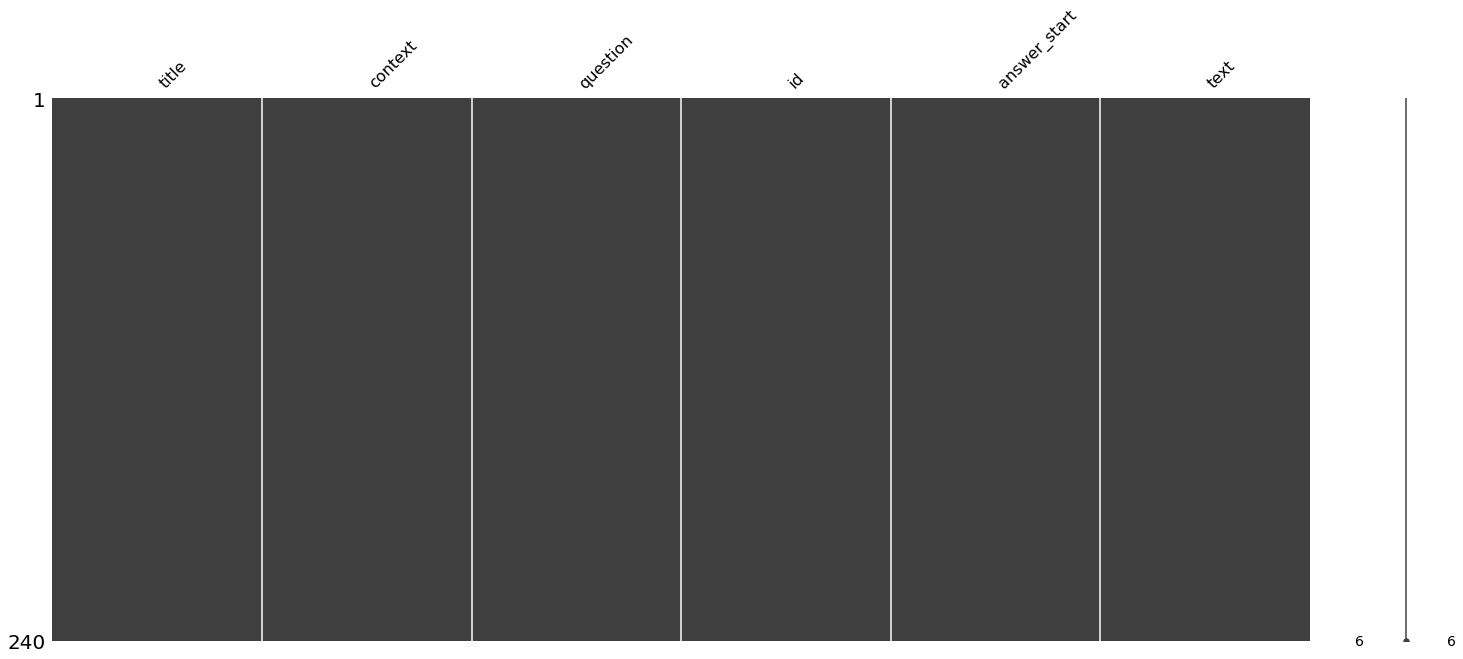

In [7]:
# 결측치 확인
msno.matrix(validation_dataset)

데이터에서의 결측치는 없다.

## 데이터 중복 확인

In [10]:
validation_dataset.describe(include='all')

,title,context,question,id,answer_start,text
count,240,240,240,240,240.000000,240
unique,228,235,240,240,NaN,240
top,티칼,태양권계면(Heliopause)은 천문학에서 태양의 태양풍을 성간매질이 멈추게 하는...,레닌이 출간한 책 중 농민의 자발적 참여에 대한 내용이 포함되어있는 것은?,mrc-0-003677,NaN,아케디아
freq,2,2,1,1,NaN,1
mean,NaN,NaN,NaN,NaN,391.516667,NaN
std,NaN,NaN,NaN,NaN,311.943965,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,NaN,154.000000,NaN
50%,NaN,NaN,NaN,NaN,317.000000,NaN
75%,NaN,NaN,NaN,NaN,536.000000,NaN


- 중복이 있는 컬럼
    - title
    - context
- 중복없는 컬럼
    - id
    - question
    - text

train과 달리, text에서의 중복이 존재하지 않는다.

title, context 부분에의 중복 형태를 알아본다.


In [13]:
def display_groupby_duplicated(dataset : pd.DataFrame , n : int , column_list : List[str]) -> pd.DataFrame:
    '''
    Usage:
        dataset: groupby 대상
        n : groupby에서 n개 이상 중복된 개수를 출력
        column_list : column 이름을 담을 list
    '''
    duplicate_results = pd.concat(g for _, g in dataset.groupby(column_list) if len(g) >= n).sort_values(column_list)
    column_name = ",".join(column_list)
    #print(type(column_name))
    print(f"{column_name} group by count : {len(duplicate_results.index)}")
    
    return duplicate_results
    

### title

In [14]:
# title 
duplicate_results = display_groupby_duplicated(validation_dataset, 2, ["title"])
display(duplicate_results.head())

title group by count : 24


,title,context,question,id,answer_start,text
61,교황 비오 11세,오랫동안 학문에 몸 담아왔던 그는 교회 내에서 급속도로 출세가도를 달리기 시작했다....,아킬레 라티가 추기경으로 추대된 해는?,mrc-1-000459,47,1932년
66,교황 비오 11세,"비오 11세는 이리 오랫동안 질병을 앓았으며, 1938년 11월 25일 몇 시간에 ...",교황 비오 11세가 사망한 연도는?,mrc-0-002767,1114,1939년
56,김준연,1947년 12월 김성수가 한민당 당수가 되면서 그는 한민당 부당수로 선임되었다. ...,김준연은 김구가 누구와 몰래 교류하고 있다고 주장했나요?,mrc-0-000939,255,공산당
132,김준연,6세 때부터 월출산을 보며 서당에 나가 한문을 배웠다 마을 서당에서 공부하다가 형편...,김준연은 김옥성과 몇 년간 함께 살았나요?,mrc-0-004015,248,60년간
118,나치 독일,1941년 6월 22일에는 독일이 독소불가침 조약을 깨고 380만 명의 추축국 군대...,러시아에 있는 다량의 천연자원을 약탈하려했던 계획은?,mrc-0-004202,67,바르바로사 작전


### context

In [16]:
# context
duplicate_results = display_groupby_duplicated(validation_dataset, 2, ["context"])
display(duplicate_results.head())

context group by count : 10


,title,context,question,id,answer_start,text
74,버트런드 러셀,러셀은 1890년 케임브리지 대학교의 트리니티 칼리지에 장학생으로 들어갔다. 그는 ...,러셀의 여자 친구의 종교는?,mrc-0-003677,215,퀘이커 교
231,버트런드 러셀,러셀은 1890년 케임브리지 대학교의 트리니티 칼리지에 장학생으로 들어갔다. 그는 ...,러셀은 누구의 가족과 함께 1889년 파리 박람회에 갔는가?,mrc-0-001162,215,퀘이커 교도였던 앨리스 페어살 스미스
6,자수장,"수를 놓을 때에 사용하는 기법을 문양의 형태에 따라 나누어 보면 선을 잇는 수, 면...",징금수는 서양 자수의 어떤 기법과 같은 기술을 사용하는가?,mrc-0-002076,192,코칭 스티치
81,자수장,"수를 놓을 때에 사용하는 기법을 문양의 형태에 따라 나누어 보면 선을 잇는 수, 면...",수를 놓을 때에 사용하는 기법 중 아주 작은 점으로 표현하는 방식은?,mrc-1-001132,101,점수
129,송나라,"요나라와의 전연의 맹세에 지불한 것으로 알려진 재물은 비단 20만필, 은 10만량이...",송나라가 돈을 지불하여 피하고자 했던 것은?,mrc-0-004495,251,전쟁


## validation_dataset : 컬럼 별 길이

### context

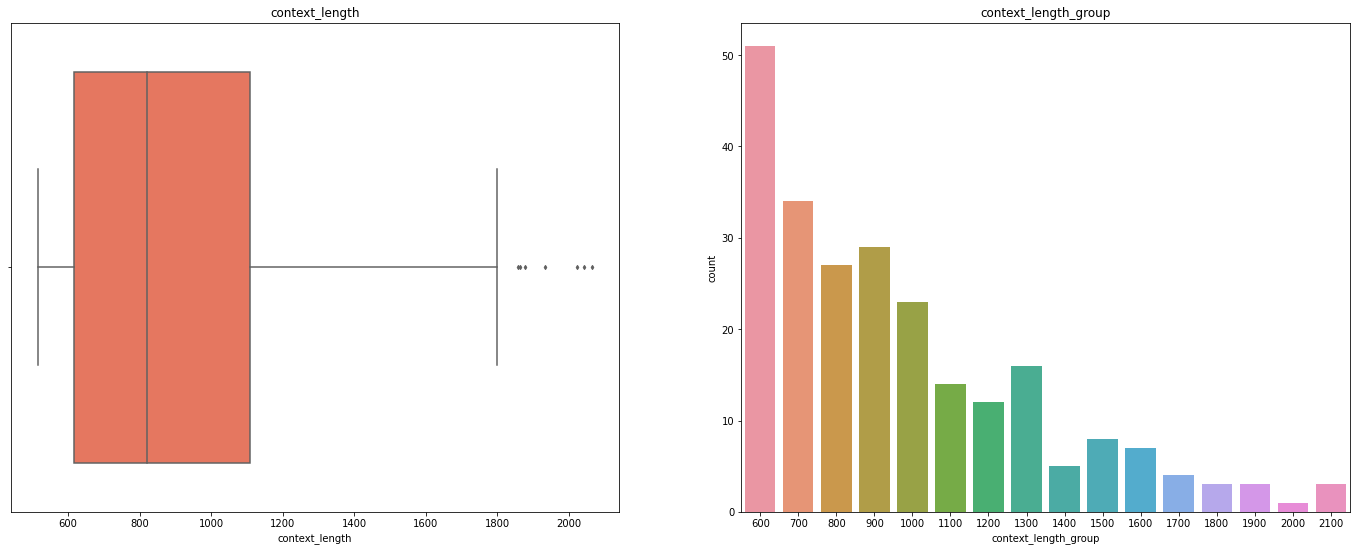

count     240.000000
mean      916.725000
std       360.032122
min       517.000000
25%       616.750000
50%       820.500000
75%      1107.250000
max      2064.000000
Name: context_length, dtype: float64

******************************
max context : 2064


,title,context,question,id,answer_start,text,context_length,context_length_group
203,나가시마 시게오,"1974년 10월 12일, 주니치의 리그 우승이 확정되면서 요미우리의 리그 10연패...",나가시마의 은퇴경기는 무엇 때문에 미뤄졌나?,mrc-1-001622,406,우천,2064,2100


In [18]:
# context
validation_dataset['context_length'] = validation_dataset['context'].map(str).apply(len)

min = validation_dataset['context_length'].min()

min = round(min,(-1)*(len(str(min))-1))
interval = pow(10,(len(str(min)) - 1))

validation_dataset['context_length_group'] = validation_dataset['context'].map(lambda x : min + ((len(x)-min)//interval * interval) + interval )


fig, axes = plt.subplots(1, 2, figsize=(24, 9))
sns.boxplot(x = 'context_length', 
            data = validation_dataset, 
            palette = "Reds", 
            ax = axes[0],
            fliersize = 3
           )

axes[0].set_title('context_length')

sns.countplot(x = 'context_length_group', 
              data = validation_dataset,
              order = sorted(validation_dataset['context_length_group'].unique()),
              # palette = "Blues",
              ax = axes[1],
           )

axes[1].set_title('context_length_group')
plt.show()

display(validation_dataset['context_length'].describe(include='all'))

print(f"*"*30)
print(f"max context : {validation_dataset['context_length'].max()}")

display(validation_dataset[validation_dataset['context_length']==validation_dataset['context_length'].max()])

train과 분포는 비슷함을 보인다.

### title

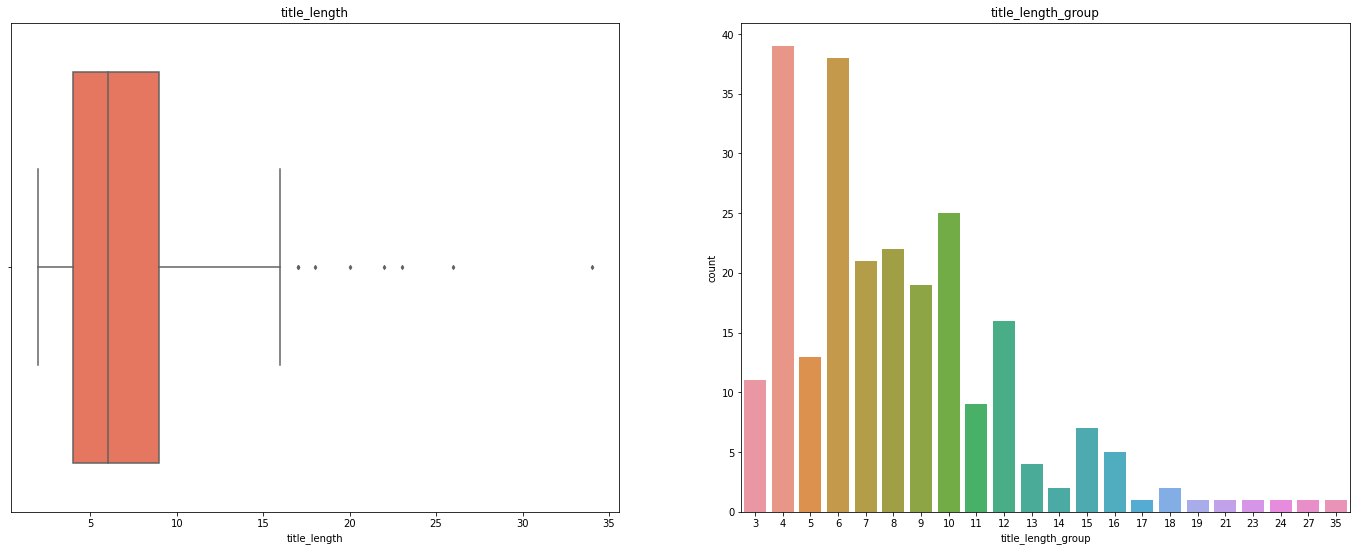

count    240.000000
mean       7.266667
std        4.389476
min        2.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       34.000000
Name: title_length, dtype: float64

******************************
max title : 2064


,title,context,question,id,answer_start,text,context_length,context_length_group,title_length,title_length_group
91,동방성련선 ~ Undefined Fantastic Object,"마계의 일부 '법계' 에 봉인되어 있던, 원래 인간이었던 마법사이다 . 『성련선』의...",뱌쿠롄과 레이무 일행은 어떤 철학 때문에 싸우게 되었나?,mrc-0-002189,459,"""인간과 요괴의 완전한 평등""",719,800,34,35


In [19]:
# title
validation_dataset['title_length'] = validation_dataset['title'].map(str).apply(len)

min = 5 # validation_dataset['title_length'].min()

min = round(min,(-1)*(len(str(min))-1))
interval = pow(10,(len(str(min)) - 1))

validation_dataset['title_length_group'] = validation_dataset['title'].map(lambda x : min + ((len(x)-min)//interval * interval) + interval )


fig, axes = plt.subplots(1, 2, figsize=(24, 9))
sns.boxplot(x = 'title_length', 
            data = validation_dataset, 
            palette = "Reds", 
            ax = axes[0],
            fliersize = 3
           )

axes[0].set_title('title_length')

sns.countplot(x = 'title_length_group', 
              data = validation_dataset,
              order = sorted(validation_dataset['title_length_group'].unique()),
              # palette = "Blues",
              ax = axes[1],
           )

axes[1].set_title('title_length_group')
plt.show()

display(validation_dataset['title_length'].describe(include='all'))
print(f"*"*30)

print(f"max title : {validation_dataset['context_length'].max()}")
display(validation_dataset[validation_dataset['title_length']==validation_dataset['title_length'].max()])

train과 분포도가 유사하다.

### question

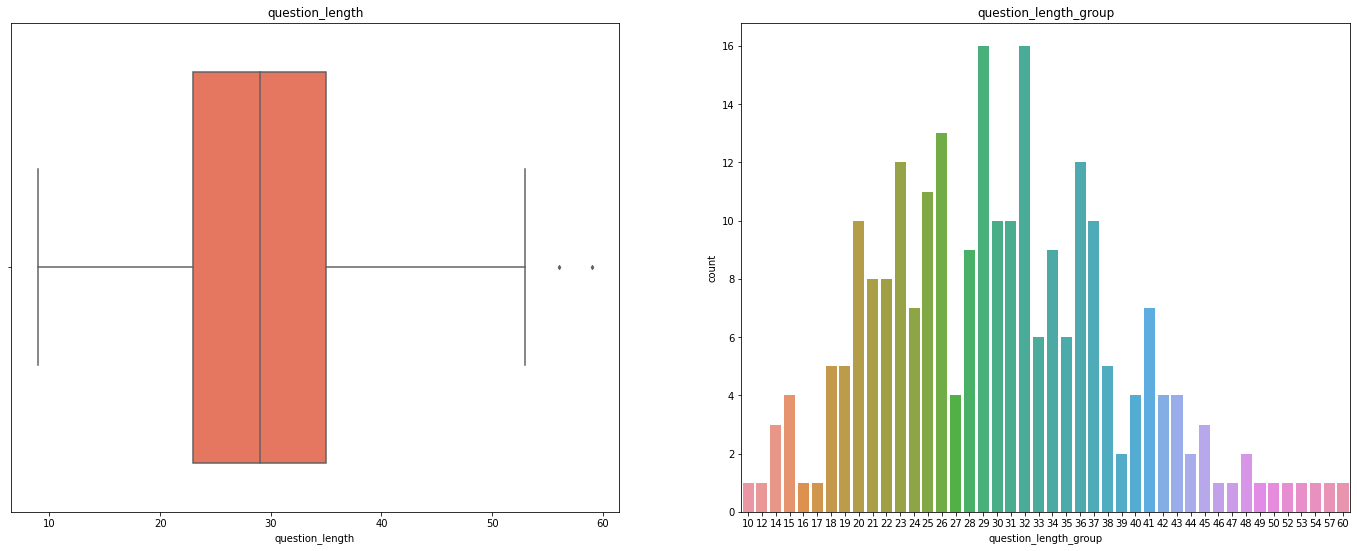

count    240.000000
mean      29.195833
std        8.728301
min        9.000000
25%       23.000000
50%       29.000000
75%       35.000000
max       59.000000
Name: question_length, dtype: float64

******************************
max question : 59


,title,context,question,id,answer_start,text,context_length,context_length_group,title_length,title_length_group,question_length,question_length_group
178,카리용 전투,"7월 6일 아침, 영국 육군은 조지 호수의 북쪽 해안에 상륙을 시작했다. 에버크롬비...",베르니츠 강과 라슈트 강이 만나는 곳 부근에서 코네티컷 연대와 만나 전투를 벌였던 ...,mrc-0-003149,335,트레뻬제 부대,852,900,6,7,59,60


In [20]:
# question
validation_dataset['question_length'] = validation_dataset['question'].map(str).apply(len)

min = 8 #validation_dataset['question_length'].min()

min = round(min,(-1)*(len(str(min))-1))
interval = pow(10,(len(str(min)) - 1))

validation_dataset['question_length_group'] = validation_dataset['question'].map(lambda x : min + ((len(x)-min)//interval * interval) + interval )


fig, axes = plt.subplots(1, 2, figsize=(24, 9))
sns.boxplot(x = 'question_length', 
            data = validation_dataset, 
            palette = "Reds", 
            ax = axes[0],
            fliersize = 3
           )

axes[0].set_title('question_length')

sns.countplot(x = 'question_length_group', 
              data = validation_dataset,
              order = sorted(validation_dataset['question_length_group'].unique()),
              # palette = "Blues",
              ax = axes[1],
           )

axes[1].set_title('question_length_group')
plt.show()

display(validation_dataset['question_length'].describe(include='all'))
print(f"*"*30)
print(f"max question : {validation_dataset['question_length'].max()}")
validation_dataset[validation_dataset['question_length']==validation_dataset['question_length'].max()]

train 과 유사하다

### text

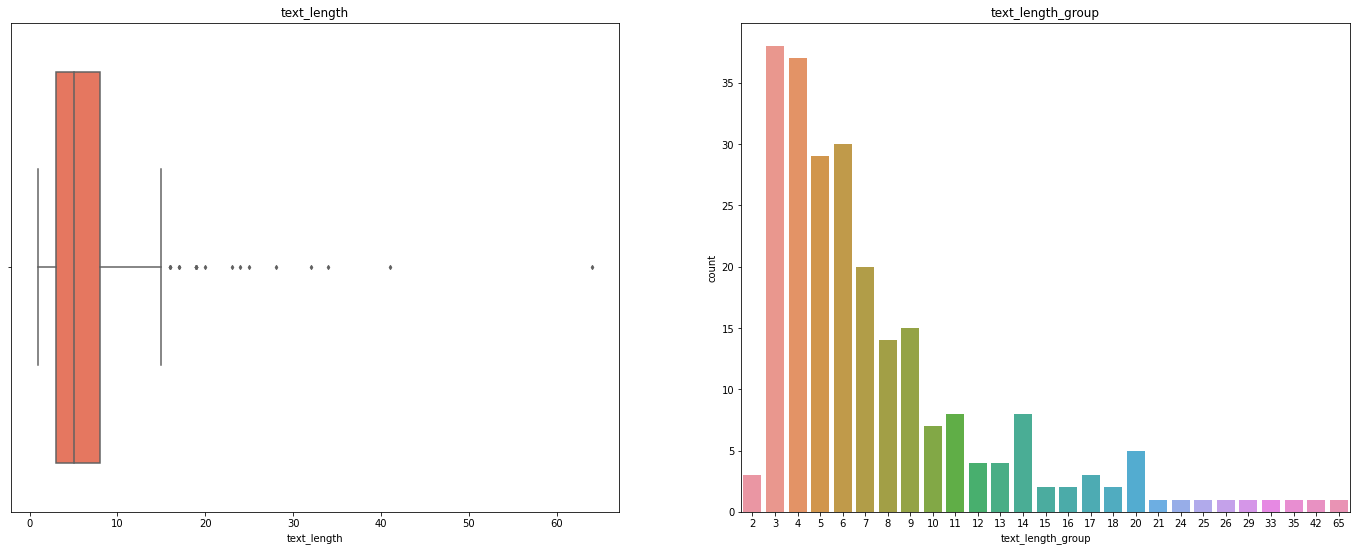

count    240.000000
mean       6.912500
std        6.858755
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       64.000000
Name: text_length, dtype: float64

******************************
max text_length : 64


,title,context,question,id,answer_start,text,context_length,context_length_group,title_length,title_length_group,question_length,question_length_group,text_length,text_length_group
109,셔틀콕,셔틀콕은 그 재질에 따라 깃털 셔틀콕과 인조 셔틀콕으로 나뉜다. 깃털로 만들어진 셔...,어느정도 규모 이상의 대회에서 깃털 셔틀콕만을 사용하는 이유는?,mrc-0-004197,637,"깃털 셔틀콕의 타구감을 선호하고, 또한 플라스틱보다 깃털 셔틀콕이 정교한 컨트롤을 ...",900,1000,3,4,35,36,64,65


In [23]:
# text
validation_dataset['text_length'] = validation_dataset['text'].map(str).apply(len)

min = 5 # validation_dataset['text_length'].min()

min = round(min,(-1)*(len(str(min))-1))
interval = pow(10,(len(str(min)) - 1))

validation_dataset['text_length_group'] = validation_dataset['text'].map(lambda x : min + ((len(x)-min)//interval * interval) + interval )


fig, axes = plt.subplots(1, 2, figsize=(24, 9))
sns.boxplot(x = 'text_length', 
            data = validation_dataset, 
            palette = "Reds", 
            ax = axes[0],
            fliersize = 3
           )

axes[0].set_title('text_length')

sns.countplot(x = 'text_length_group', 
              data = validation_dataset,
              order = sorted(validation_dataset['text_length_group'].unique()),
              # palette = "Blues",
              ax = axes[1],
           )

axes[1].set_title('text_length_group')
plt.show()

display(validation_dataset['text_length'].describe(include='all'))
print(f"*"*30)
print(f"max text_length : {validation_dataset['text_length'].max()}")
validation_dataset[validation_dataset['text_length']==validation_dataset['text_length'].max()]


### answer_start

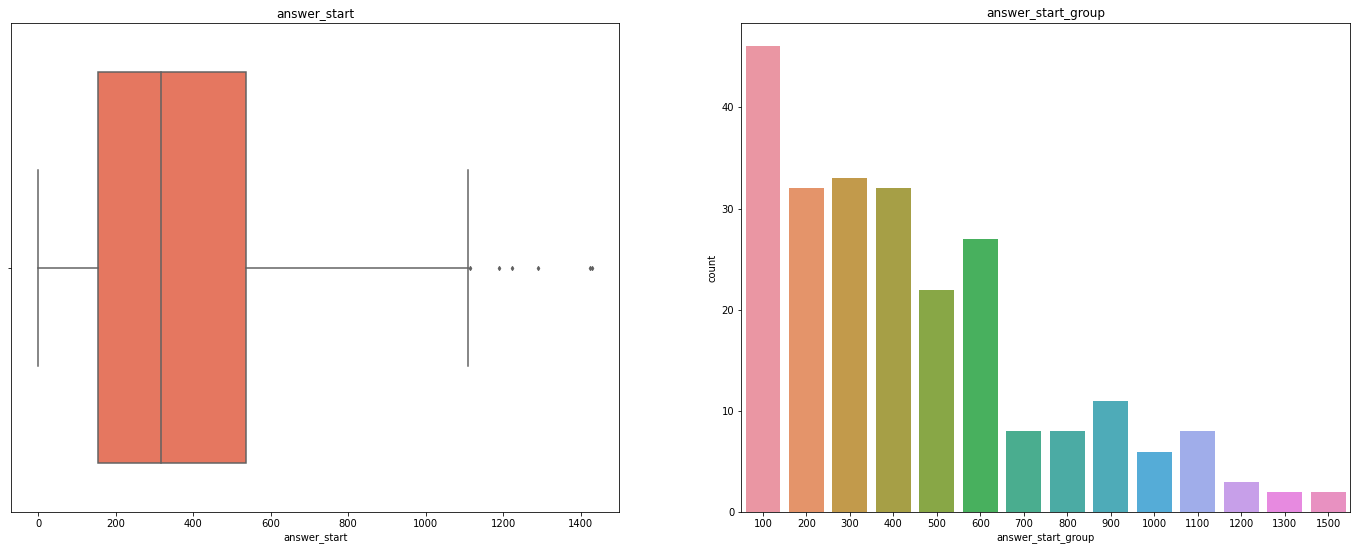

count     240.000000
mean      391.516667
std       311.943965
min         0.000000
25%       154.000000
50%       317.000000
75%       536.000000
max      1429.000000
Name: answer_start, dtype: float64

******************************
max answer_start_length : 1429
{14: '남은 사유지를 가진 지주들은 정부측의 한 층 강한 압력을 받았으나 반대동맹에 남겠다는 결의가 강했으며 한 층 더 강한 반대운동이 '
     '시작되었다. \\n\\n반대파는 햐쿠리 비행장 반대 운동을 참고하여 토지를 잘게 세분화하여 공항 예정지 매수 교섭을 어렵게 하기 '
     '위해 혁신정당의 주도 하에 토지 1평씩을 소유자나 지원자가 서로 매매해 나눠 가져 일평지주 운동을 벌였으며, 또한 입목에 관한 '
     '법률에 따라 1명씩 입목을 서로 매매하고 심은 후 표찰을 내거는 입목 트러스트 운동도 진행하였다. 일평지주운동은 1966년 8월 '
     '29일 시작하여 토지 내 33곳 2.1 ha의 영역의 공유지를 사용하였으며 이 토지의 소유자는 1,300명이 넘었다. 이 토지의 '
     '등기에는 일본 사회당의 주요 의원 이름도 올라가 있었다. \\n\\n초기부터 공항반대운동의 조직 지도에는 혁신정당이 관여하였으나, '
     '1967년 8월 16일 반대동맹이 "모든 민주세력과의 공동투쟁"으로 적대적인 신좌익당파(반요요기파)와 공투를 표명하며 일본공산당과 '
     '반대동맹 간 관계가 틀어지기 시작하였다\\n\\n8월 21일 도모노 지바현지사는 토지수용법에 의거하여 공항공단이 각 토지의 '
     '출입조사를 시행하겠다고 공표하였다. 이 기간 동안 반대동맹은 청원, 시위, 서명운동, 해직청구 등 다양한 항의 운동을 하였으나 '
     '뚜렷한 성과를 거두지 못했다. 당시 반대파 주민 중에서는 자유민주당 지지자들도 있어 이들은 자민당 의원에게 진정도 넣었으나 진정 '
     '후에도 이 의원들이 공항 찬성 입장을 밝히면서 주민 사이의 갈등이 확산되었다\\n\\n10월 10일 이른 아침, 외곽 측량용 '
     '쇠말뚝을 박기 위해 공항공단 직원들이 경시청, 지바현 경찰, 가나가와현 경찰의 기동대 약 1,500명의

,title,context,question,id,answer_start,text,context_length,context_length_group,title_length,title_length_group,question_length,question_length_group,text_length,text_length_group,answer_start_group
14,산리즈카 투쟁,남은 사유지를 가진 지주들은 정부측의 한 층 강한 압력을 받았으나 반대동맹에 남겠다...,반대동맹이 공산당과 갈라서겠다고 얘기한 날은 언제인가?,mrc-0-003032,1429,1967년 11월 15일,1592,1600,7,8,30,31,13,14,1500


In [24]:
# answer_start
validation_dataset['answer_start'] = validation_dataset['answer_start'].map(int)

min = 100 # validation_dataset['answer_start'].mean()

min = round(min,(-1)*(len(str(min))-1))

interval = pow(10,(len(str(min)) - 1))

validation_dataset['answer_start_group'] = validation_dataset['answer_start'].map(lambda x : min + (x//interval * 100) )

validation_dataset['answer_start'] = validation_dataset['answer_start'].map(int)

fig, axes = plt.subplots(1, 2, figsize=(24, 9))
sns.boxplot(x = 'answer_start', 
            data = validation_dataset, 
            palette = "Reds", 
            ax = axes[0],
            fliersize = 3
           )

axes[0].set_title('answer_start')

sns.countplot(x = 'answer_start_group', 
              data = validation_dataset,
              order = sorted(validation_dataset['answer_start_group'].unique()),
              # palette = "Blues",
              ax = axes[1],
           )

axes[1].set_title('answer_start_group')
plt.show()
display(validation_dataset['answer_start'].describe(include='all'))
print(f"*"*30)
print(f"max answer_start_length : {validation_dataset['answer_start'].max()}")
pprint.pprint(validation_dataset[validation_dataset['answer_start']==validation_dataset['answer_start'].max()].to_dict()['context'])
display(validation_dataset[validation_dataset['answer_start']==validation_dataset['answer_start'].max()])


### conclusion

train 데이터와 validation의 컬럼 별 길이에서 거의 유사한 분포를 보이고 있다.  
다만, context의 길이는 validation에서 더 긴 것을 확인할 수 있다.